In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
import os

from tqdm import tqdm

In [3]:
## Code from Deepmind's Github
load_data = np.load("dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
imgs = load_data['imgs']
latents_values = load_data['latents_values']
latents_classes = load_data['latents_classes']
metadata = load_data['metadata'][()]

experiment_name = "VAEMultipleSpriteColor"

print('Metadata: \n', metadata)

Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.18879

In [4]:
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

def show_images_grid(imgs_, num_images=25, cmap='Greys_r'):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            if not cmap is None:
                ax.imshow(imgs_[ax_i], cmap=cmap,  interpolation='nearest')
            else:
                ax.imshow(imgs_[ax_i]*255, interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

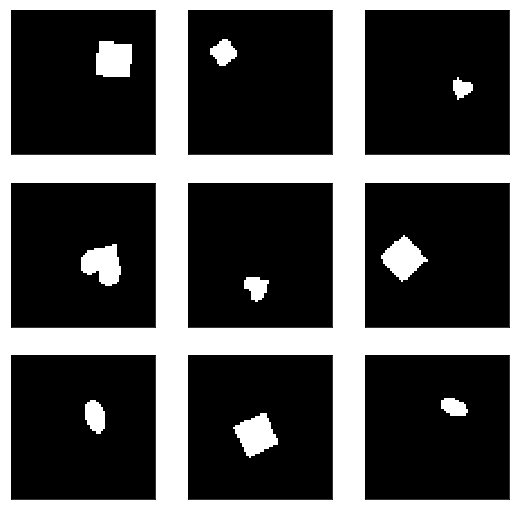

In [5]:
latents_sampled = sample_latent(size=200)
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

show_images_grid(imgs_sampled, 9, cmap='gray')

In [6]:
def create_color(base_image):
    all_color = itertools.product([0, 1], repeat=3)
    all_images = []
    for r, g, b in all_color:
        if (r, g, b) == (0, 0, 0):
            continue
        new_color = np.stack([
            base_image*r,
            base_image*g,
            base_image*b
        ], axis=-1)

        all_images.append(new_color)
    return all_images

In [7]:
all_combination_length = len(list(itertools.combinations(imgs_sampled, r=2)))
print(all_combination_length)

19900


In [10]:
all_batches = []
for batch in range(5):
    latents_sampled = sample_latent(size=200)
    indices_sampled = latent_to_index(latents_sampled)
    imgs_sampled = imgs[indices_sampled]
    t = []
    with tqdm(total=all_combination_length) as pbar:
        for i, (a, b) in enumerate(itertools.combinations(imgs_sampled, r=2)):
            a = create_color(a)
            b = create_color(b)

            for c1, c2 in itertools.product(a, b):
                total = c1 + c2
                total[total > 1] = 1
                t.append(total)

            pbar.update(1)

    t = np.stack(t)
    t = np.reshape(t, (-1, 64, 64, 3))
    np.savez_compressed(f'dsprites-dataset/dsprites_multiple_shapes{batch}.npz', data=t)

100%|██████████| 19900/19900 [00:19<00:00, 1045.93it/s]
